# Motivation

The goal of this notebook is to verify the state estimation and optimization algorithms integrated into the sofa control loop.

In [378]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control
import dask.array as da
import cvxpy as cp
import opinf


config = dotenv_values(".env")
from util import *

# Read in System Matrices

In [379]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/verificationData/estimationTest2/"
# Read in system and gain matrices from .mat file
systemMats = scipy.io.loadmat(filepath + "romSystemMatricesAndGains_22dim_3train_2test.mat")
# ERA matrices
A_era = systemMats["A_era"]
B_era = systemMats["B_era"]
C_era = systemMats["C_era"]
D_era = systemMats["D_era"]
L_era = systemMats["L_era"]
# DMDc Matrices
A_dmdc = systemMats["A_dmdc"]
B_dmdc = systemMats["B_dmdc"]
C_dmdc = systemMats["C_dmdc"]
L_dmdc = systemMats["L_dmdc"]
# LOpInf Matrices
A_lopinf = systemMats["A_lopinf"]
B_lopinf = systemMats["B_lopinf"]
C_lopinf = systemMats["C_lopinf"]
D_lopinf = systemMats["D_lopinf"]
L_lopinf = systemMats["L_lopinf"]

# Read in offset vector
x0 = systemMats["x0"]

# Read input data

In [380]:
# Load in data from npy file
data = np.load(filepath + "processedData_policySeed_0.npz")

Y_fom = data["reducedCenterlineData"]
U_fom = data["inputData"]
Y0_fom = data["reducedCenterlineData"][0,:]



timesteps = Y_fom.shape[0]



In [381]:
Y_fom = Y_fom.T
U_fom = U_fom.T

# Center outputs wrt Y0
Y_fom = Y_fom - Y0_fom.reshape(-1,1)


In [382]:
U_fom.shape

(6, 500)

In [383]:
# Initialize arrays to store data

# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps)) # Closed loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps)) # Open loop era observer

# Iterate through each timestep
for i in range(timesteps-1):
    # Update Observer State
    x_hat_era[:,i+1] = A_era @ x_hat_era[:,i] + B_era @ U_fom[:,i] + L_era @ (Y_fom[:,i] - y_hat_era[:,i])
    # Update Observer Output
    y_hat_era[:,i+1] = C_era @ x_hat_era[:,i+1] + D_era @ U_fom[:,i]

In [384]:
# Initialize arrays to store data from online observer
x_hat_era_online = np.zeros((A_era.shape[0], timesteps)) # Closed loop era observer
y_hat_era_online = np.zeros((C_era.shape[0], timesteps)) # Open loop era observer
y_groundTruth_online = np.zeros((C_era.shape[0], timesteps)) # Open loop era observer
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        x_hat_era_online[:,i] = f["x_hat"][()].squeeze()
        y_hat_era_online[:,i] = C_era @ x_hat_era_online[:,i]+ D_era @ U_fom[:,i]
        y_groundTruth_online[:,i] = f["y"][()].squeeze()

In [385]:
# Compare averaging matrices to see if theyre the same
avgMat_offline = np.load(filepath + "avgMatrix.npy")
with h5py.File(onlineObs_filename, 'r') as f:
    avgMat_online= f["avgMatrix"][()]


In [386]:
# Compare sizes of matrices to see if theyre the same
print("Offline Averages Matrix")
print(avgMat_offline.shape)
print("Online Averages Matrix")
print(avgMat_online.shape)
# Find the indices of the matrices that are different
diff_idx = np.where(avgMat_offline-avgMat_online>=1e-8)
# Print the indices of the matrices that are different 
print("Indices of differences") 
print(diff_idx)
# Print the values of the difference matrix at those indices
print("Values of differences")
print(avgMat_offline[diff_idx])
print(avgMat_online[diff_idx])


Offline Averages Matrix
(20, 6657)
Online Averages Matrix
(20, 6657)
Indices of differences
(array([], dtype=int64), array([], dtype=int64))
Values of differences
[]
[]


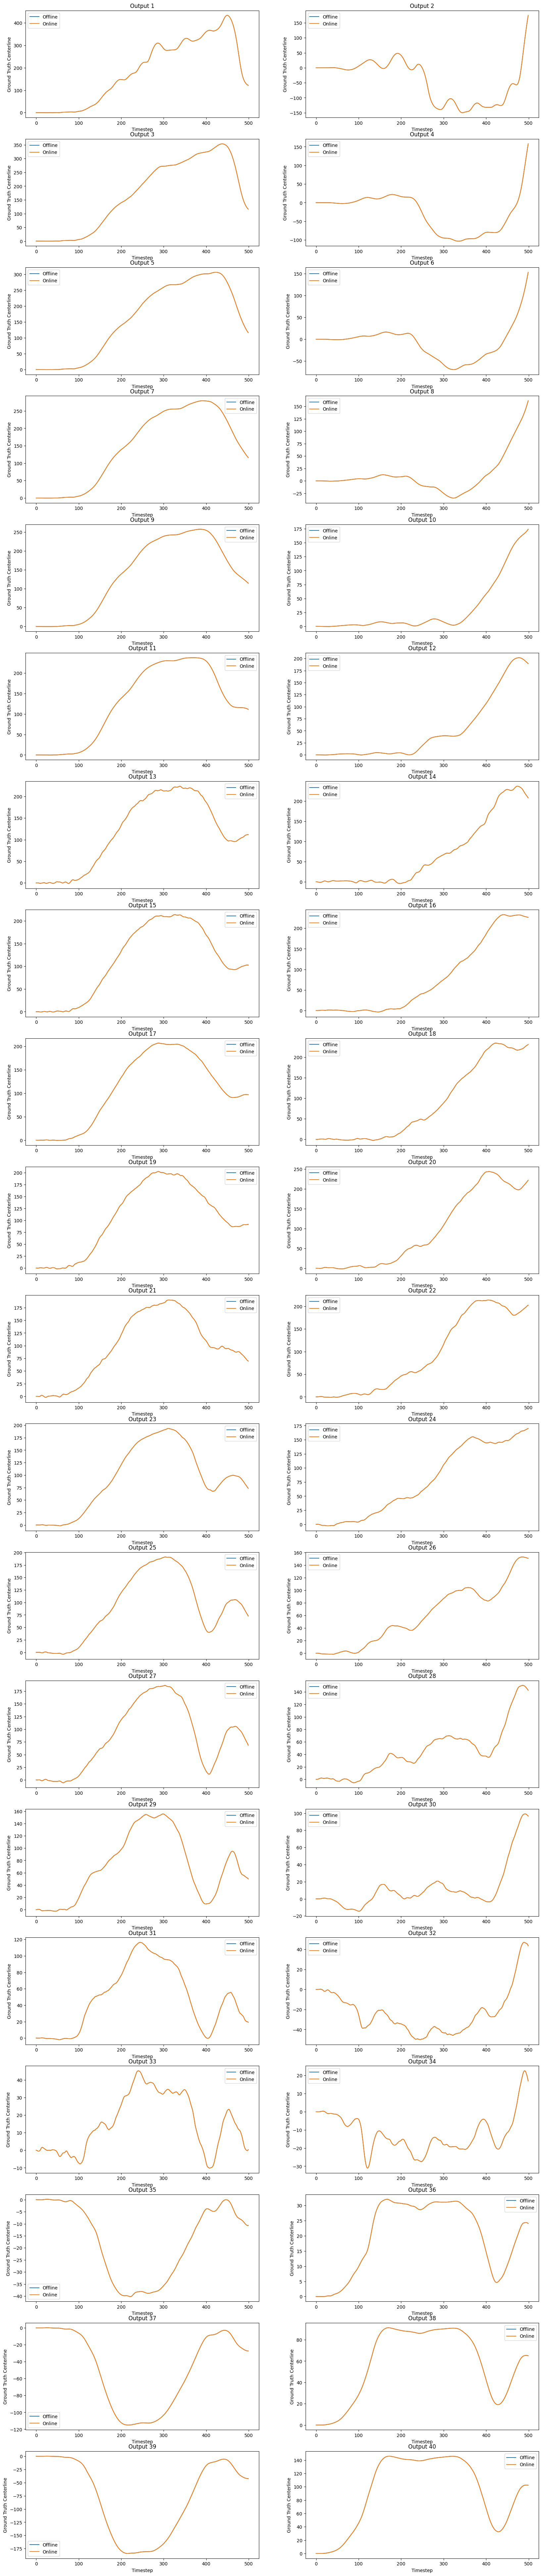

In [387]:
# Plot ground truths for each output as a subfigure for the online and offline centerlines
fig, ax = plt.subplots(C_era.shape[0]//2,2, figsize=(20,100))
# Iterate through each output plotting evens in the first column and odds in the second
for outputIndex in range(C_era.shape[0]):
    # Plot offline centerline
    ax[outputIndex//2,outputIndex%2].plot(Y_fom[outputIndex,:timesteps], label="Offline")
    # Plot online centerline
    ax[outputIndex//2,outputIndex%2].plot(y_groundTruth_online[outputIndex,:timesteps], label="Online")
    ax[outputIndex//2,outputIndex%2].legend()
    ax[outputIndex//2,outputIndex%2].set_title("Output " + str(outputIndex+1))
    ax[outputIndex//2,outputIndex%2].set_xlabel("Timestep")
    ax[outputIndex//2,outputIndex%2].set_ylabel("Ground Truth Centerline")

## Comparing State Estimation Online vs Offline

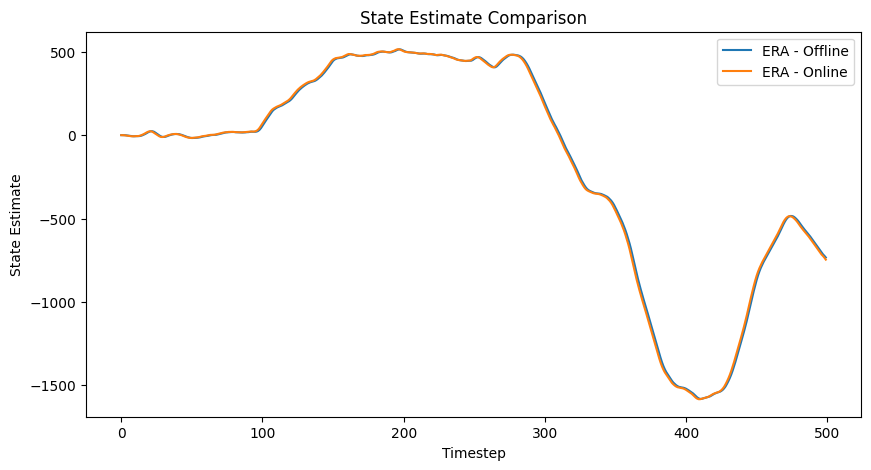

In [388]:
# Plot first state estimates from each observer
plt.figure(figsize=(10,5))
plt.plot(x_hat_era[0,:], label="ERA - Offline")
plt.plot(x_hat_era_online[0,:], label="ERA - Online")
plt.legend()
plt.title("State Estimate Comparison")
plt.xlabel("Timestep")
plt.ylabel("State Estimate")
plt.show()

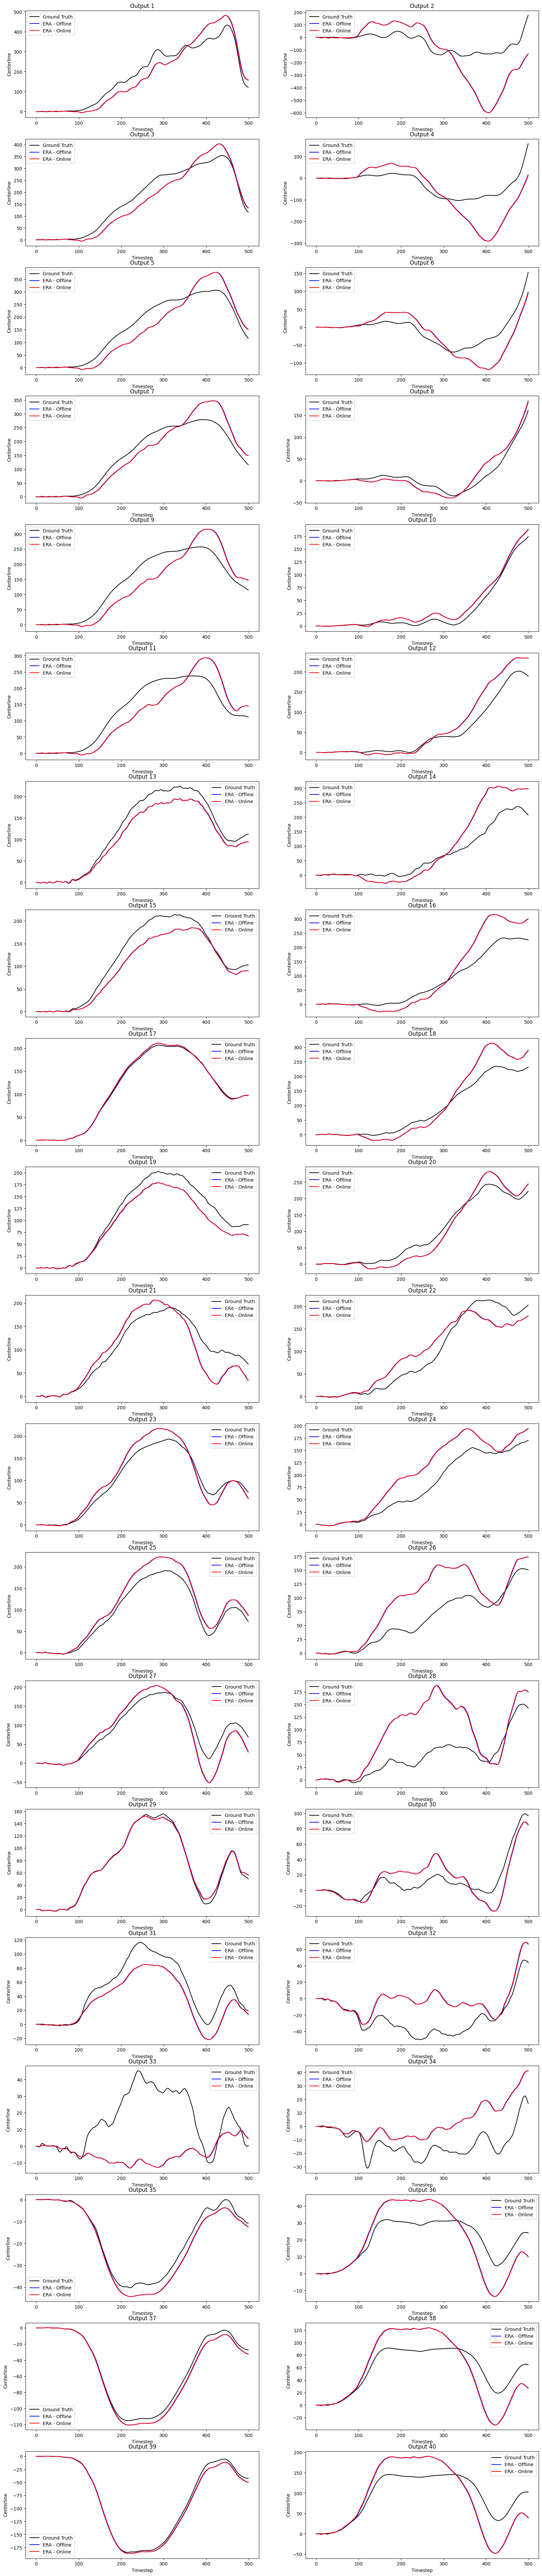

In [389]:
# Plot all outputs from online and offline estimators against ground truth
fig, ax = plt.subplots(C_era.shape[0]//2,2, figsize=(20,100))
# Iterate through each output plotting evens in the first column and odds in the second
for outputIndex in range(C_era.shape[0]):
    # Plot offline ground truth centerline
    ax[outputIndex//2,outputIndex%2].plot(Y_fom[outputIndex,:timesteps], label="Ground Truth", color="black")
    # Plot offline centerline estimate
    ax[outputIndex//2,outputIndex%2].plot(y_hat_era[outputIndex,:timesteps], label="ERA - Offline", color="blue")
    # Plot online centerline estimate
    ax[outputIndex//2,outputIndex%2].plot(y_hat_era_online[outputIndex,:timesteps], label="ERA - Online", color = "red")
    ax[outputIndex//2,outputIndex%2].legend()
    ax[outputIndex//2,outputIndex%2].set_title("Output " + str(outputIndex+1))
    ax[outputIndex//2,outputIndex%2].set_xlabel("Timestep")
    ax[outputIndex//2,outputIndex%2].set_ylabel("Centerline")

Text(0, 0.5, 'Output')

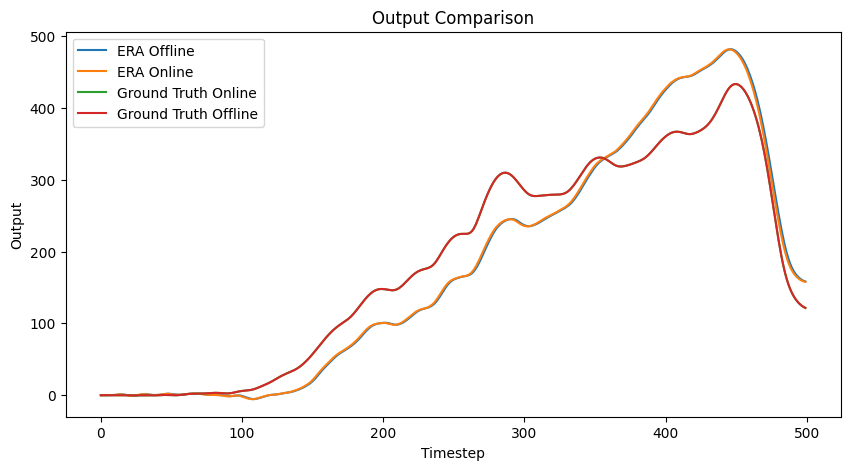

In [390]:
# Plot  groundtruths: Online values are solid lines offline values are dotted lines
outputIndex = 0
plt.figure(figsize=(10,5))
plt.plot(y_hat_era[outputIndex,:], label="ERA Offline")
plt.plot(y_hat_era_online[outputIndex,:], label="ERA Online")
plt.plot(y_groundTruth_online[outputIndex,:], label="Ground Truth Online")
plt.plot(Y_fom[outputIndex,:], label="Ground Truth Offline")
plt.legend()
plt.title("Output Comparison")
plt.xlabel("Timestep")
plt.ylabel("Output")


In [391]:
y_groundTruth_online[:,:timesteps].shape

(40, 500)

In [392]:
y_groundTruth_online[:,:timesteps].shape

(40, 500)

In [393]:
# Compute relative error of centerline outputs 
centerlineCompError_rel = np.linalg.norm(y_groundTruth_online[:,:timesteps] - Y_fom[:,:timesteps],ord='fro')/np.linalg.norm(Y_fom[:,:timesteps])*100
centerlineCompError_rel

5.284871214556274e-14

In [394]:
np.linalg.norm(y_hat_era_online)

17892.228343741594

# Verifying Trajectory Planner

The goal of this section is to make sure that the trajectory planning block is appropriately planning reference trajectories for the outputs of the robot.

Some things to keep in mind are:
1. Correspondance of points: Making sure that the permutation of points in the reference frame matches that of the points in the output.
2. Making sure that the offset of the points is taken into account


#### Functions for trajectory generation

In [427]:
n_redCenterline = 20
# helper function to define reference trajectories
# Function to provide coordinates of discretized centerline at a given time
def generateReferenceCoords(time,numPoints=20,a_max=10,l=1114.1947932504659,k=10,omega=7,x_shift = 0,z_shift = 0):
    # Generate 10 times number of x coordinates as desired points
    x = np.linspace(0,l,numPoints*1000)
    dx = x[1]-x[0]
    # Compute integrand of arc length integral
    integrand = np.sqrt(1+(a_max/l*(np.exp(x/l-1)*(k*np.cos(k/l*x+omega*time)-np.sin(-k/l*x+omega*time))))**2)
    # Use first order quadrature to compute integral
    integrand = integrand*dx
    integrand = np.cumsum(integrand)
    # Find where the integral is closest to the desired arc length
    larc_des = np.linspace(0,l,numPoints)
    x_ref_0 = np.linspace(0,l,numPoints) # Initial x coordinate of each reference point
    x_ref = np.zeros(numPoints)
    z_ref = np.zeros(numPoints)
    for i in range(numPoints):
        idx = np.argmin(np.abs(integrand-larc_des[i]))
        x_ref[i] = x[idx]-x_ref_0[i] # We subtract off the initial x coordinate to make the first point at the origin
        # Compute z value at this point
        z_ref[i] = a_max*np.exp(x[idx]/l-1)*np.sin(k*x[idx]/l-omega*time)
    # z = z-z[0]
    x_ref = x_ref+x_shift
    z_ref = z_ref+z_shift
    # Flip sign of x coordinates to take into account coordinate frame facing out from the front of the eel
    x_ref = -x_ref
    # Flip order of reference coords
    x_ref = np.flip(x_ref)
    z_ref = np.flip(z_ref)
    y_ref = np.hstack((x_ref.reshape(-1,1),z_ref.reshape(-1,1))).reshape(-1,1).squeeze()
    return y_ref

# Helper function to define reference trajectories using reference coords function above
def generateReferenceTrajectory(time,numPoints=20,a_max=10,l=1114.1947932504659,k=10,omega=7,x_shift = 0,z_shift = 0, T=1,  *args, **kwargs):
    '''
    T - time horizon of reference trajectory
    '''
    # Initialize reference trajectory
    y_ref = np.zeros((n_redCenterline*2,T))
    # Loop over time horizon
    for i in range(T):
        # Generate reference coordinates
        y_ref[:,i] = generateReferenceCoords(time = time+i,numPoints=numPoints,a_max=a_max,l=l,k=k,omega=omega,x_shift=x_shift,z_shift=z_shift).reshape(-1,1).squeeze()
    return y_ref


In [428]:
t = 0
T = 50
y_ref = generateReferenceTrajectory(time = t,T = T+1,a_max=30) 


In [429]:
y_ref.shape

(40, 51)

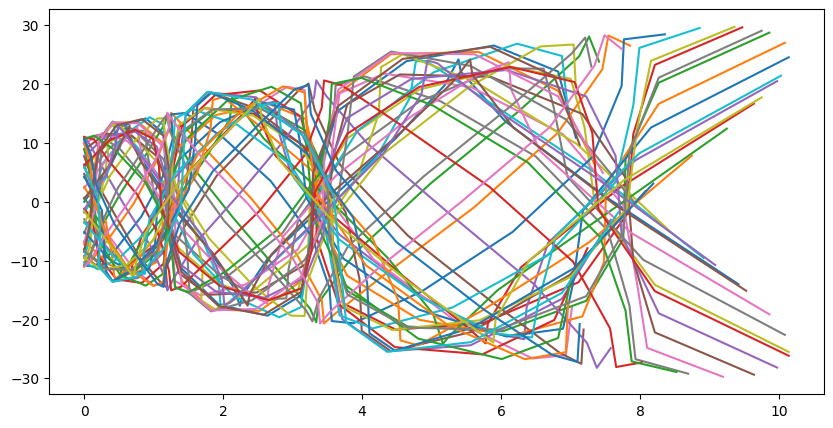

In [430]:
# Extract xs and zs from reference trajectory
x_ref = y_ref[0:2*n_redCenterline:2,:]
z_ref = y_ref[1:2*n_redCenterline:2,:]

# Plot reference trajectory
plt.figure(figsize=(10,5))
# plt.plot(y_ref[0,:])
plt.plot(x_ref,z_ref)